In [1]:
# Install the required libraries
#SAM
#!pip install git+https://github.com/facebookresearch/segment-anything.git
##Transformers
#!pip install -q git+https://github.com/huggingface/transformers.git
##Datasets to prepare data and monai if you want to use special loss functions
#!pip install datasets
#!pip install -q monai
#Patchify to divide large images into smaller patches for training. (Not necessary for smaller images)
#!pip install patchify

  Cloning https://github.com/facebookresearch/segment-anything.git to /private/var/folders/80/kgpm907s6db4tz7cvmwtd6l80000gn/T/pip-req-build-qy5asfdt
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /private/var/folders/80/kgpm907s6db4tz7cvmwtd6l80000gn/T/pip-req-build-qy5asfdt
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done


In [11]:
!git add .
!git commit -m "creates a combined version with a dataset"
!git push

[main 4658a1a] creates a combined version with a dataset
 1 file changed, 238 insertions(+), 2 deletions(-)
Enumerating objects: 5, done.
Counting objects: 100% (5/5), done.
Delta compression using up to 8 threads
Compressing objects: 100% (3/3), done.
Writing objects: 100% (3/3), 3.36 KiB | 3.36 MiB/s, done.
Total 3 (delta 1), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (1/1), completed with 1 local object.
To https://github.com/RudimentaryChef/FissionTrack.git
   439afa3..4658a1a  main -> main


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tifffile
import os
from patchify import patchify  #Only to handle large images
import random
from scipy import ndimage

In [2]:
large_images = tifffile.imread("/Users/adikrish/Desktop/Adam.tif")
large_masks = tifffile.imread("/Users/adikrish/Desktop/Eve.tif")

In [6]:
if large_images.ndim == 2 :
    large_images = large_images.reshape(1, large_images.shape[0], large_images.shape[1])
if large_masks.ndim == 2:
    large_masks = large_masks.reshape(1, large_masks.shape[0], large_masks.shape[1])

In [7]:
all_img_patches = []
#Desired patch size for smaller images and step size.
patch_size = 256
step = 256
for img in range(large_images.shape[0]):
    large_image = large_images[img]
    patches_img = patchify(large_image, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_img.shape[0]):
        for j in range(patches_img.shape[1]):

            single_patch_img = patches_img[i,j,:,:]
            all_img_patches.append(single_patch_img)

images = np.array(all_img_patches)

#Let us do the same for masks
all_mask_patches = []
for img in range(large_masks.shape[0]):
    large_mask = large_masks[img]
    patches_mask = patchify(large_mask, (patch_size, patch_size), step=step)  #Step=256 for 256 patches means no overlap

    for i in range(patches_mask.shape[0]):
        for j in range(patches_mask.shape[1]):

            single_patch_mask = patches_mask[i,j,:,:]
            single_patch_mask = (single_patch_mask / 255.).astype(np.uint8)
            all_mask_patches.append(single_patch_mask)

masks = np.array(all_mask_patches)

In [8]:
images.shape

(40, 256, 256)

In [9]:
# Create a list to store the indices of non-empty masks
valid_indices = [i for i, mask in enumerate(masks) if mask.max() != 0]
# Filter the image and mask arrays to keep only the non-empty pairs
filtered_images = images[valid_indices]
filtered_masks = masks[valid_indices]
print("Image shape:", filtered_images.shape)  # e.g., (num_frames, height, width, num_channels)
print("Mask shape:", filtered_masks.shape)

Image shape: (40, 256, 256)
Mask shape: (40, 256, 256)


In [10]:
from datasets import Dataset
from PIL import Image

# Convert the NumPy arrays to Pillow images and store them in a dictionary
dataset_dict = {
    "image": [Image.fromarray(img) for img in filtered_images],
    "label": [Image.fromarray(mask) for mask in filtered_masks],
}

# Create the dataset using the datasets.Dataset class
dataset = Dataset.from_dict(dataset_dict)

In [12]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 40
})

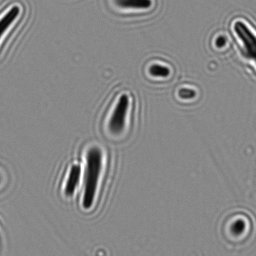

In [13]:
#Visualizes an example
example = dataset[0]
image = example["image"]
image

(-0.5, 255.5, 255.5, -0.5)

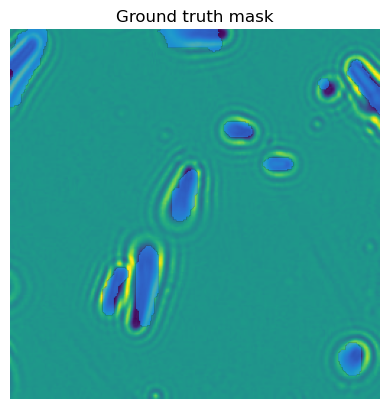

In [14]:
import matplotlib.pyplot as plt
import numpy as np 
#shows us our ground truth masks
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)

fig, axes = plt.subplots()

axes.imshow(np.array(image))
ground_truth_seg = np.array(example["label"])
show_mask(ground_truth_seg, axes)
axes.title.set_text(f"Ground truth mask")
axes.axis("off")


In [15]:
#the bounding boxes
def get_bounding_box(ground_truth_map):
  # get bounding box from mask
  y_indices, x_indices = np.where(ground_truth_map > 0)
  x_min, x_max = np.min(x_indices), np.max(x_indices)
  y_min, y_max = np.min(y_indices), np.max(y_indices)
  # add perturbation to bounding box coordinates
  H, W = ground_truth_map.shape
  x_min = max(0, x_min - np.random.randint(0, 20))
  x_max = min(W, x_max + np.random.randint(0, 20))
  y_min = max(0, y_min - np.random.randint(0, 20))
  y_max = min(H, y_max + np.random.randint(0, 20))
  bbox = [x_min, y_min, x_max, y_max]

  return bbox

In [16]:
from torch.utils.data import Dataset

class SAMDataset(Dataset):
  def __init__(self, dataset, processor):
    self.dataset = dataset
    self.processor = processor

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]
    image = item["image"]
    ground_truth_mask = np.array(item["label"])

    # get bounding box prompt
    prompt = get_bounding_box(ground_truth_mask)

    # prepare image and prompt for the model
    inputs = self.processor(image, input_boxes=[[prompt]], return_tensors="pt")

    # remove batch dimension which the processor adds by default
    inputs = {k:v.squeeze(0) for k,v in inputs.items()}

    # add ground truth segmentation
    inputs["ground_truth_mask"] = ground_truth_mask

    return inputs

In [17]:
from transformers import SamProcessor

processor = SamProcessor.from_pretrained("facebook/sam-vit-base")

In [18]:
train_dataset = SAMDataset(dataset=dataset, processor=processor)

In [19]:
example = train_dataset[0]
for k,v in example.items():
  print(k,v.shape)

ValueError: Unsupported number of image dimensions: 2

In [21]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

In [22]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

ValueError: Unsupported number of image dimensions: 2

In [23]:
batch["ground_truth_mask"].shape

NameError: name 'batch' is not defined

In [24]:
from transformers import SamModel 

model = SamModel.from_pretrained("facebook/sam-vit-base")

# make sure we only compute gradients for mask decoder
for name, param in model.named_parameters():
  if name.startswith("vision_encoder") or name.startswith("prompt_encoder"):
    param.requires_grad_(False)

In [25]:
from torch.optim import Adam
import monai

# Note: Hyperparameter tuning could improve performance here
optimizer = Adam(model.mask_decoder.parameters(), lr=1e-5, weight_decay=0)

seg_loss = monai.losses.DiceCELoss(sigmoid=True, squared_pred=True, reduction='mean')

In [30]:
from tqdm import tqdm
from statistics import mean
import torch

num_epochs = 100

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(num_epochs):
    epoch_losses = []
    
    # Assuming 'train_dataset' is your dataset object
    for data_sample in tqdm(train_dataset, desc=f"Epoch {epoch+1}"):
        # Extract data from the sample
        image = data_sample['image']  # Assuming 'image' contains your image data
        label = data_sample['label']  # Assuming 'label' contains your input boxes and ground truth masks
        
        # Reshape image to have channels dimension
        image = image.unsqueeze(0)  # Add batch dimension
        image = image.unsqueeze(0)  # Add channels dimension
        
        # Forward pass
        outputs = model(pixel_values=image.to(device),
                        input_boxes=label['input_boxes'].to(device),
                        multimask_output=False)
        
        # Compute loss
        predicted_masks = outputs.pred_masks.squeeze(1)
        ground_truth_mask = label['ground_truth_mask'].unsqueeze(0).float().to(device)  # Assuming 'ground_truth_mask' is part of the label
        loss = seg_loss(predicted_masks, ground_truth_mask)
        
        # Backward pass (compute gradients of parameters w.r.t. loss)
        optimizer.zero_grad()
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        epoch_losses.append(loss.item())
    
    # Print epoch statistics
    print(f'EPOCH: {epoch}')
    print(f'Mean loss: {mean(epoch_losses)}')


Epoch 1:   0%|                                           | 0/40 [00:00<?, ?it/s]


ValueError: Unsupported number of image dimensions: 2

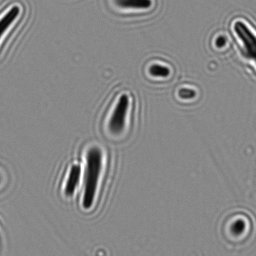